In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, roc_curve
from scipy.stats import entropy

In [16]:
# Load the CSV file
result_csv_path = '/opt/challenge/analyzer/malignancy/outputs/inference_results/result_5_3_0rc2.csv'
df = pd.read_csv(result_csv_path)
# df = df[df["mode"] == "val"]
df = df[df["mode"] == "test"]
df.head()

,mode,annot_ids,annotation,prob_ensemble,prob_model_0,prob_model_1,prob_model_2,prob_model_3,prob_model_4,prob_model_5,prob_model_6
0,test,102387_1_20000102,0.0,0.119986,0.106644,0.054753,0.111385,0.158747,0.130680,0.137001,0.140696
1,test,102387_1_20010102,0.0,0.100636,0.089371,0.061994,0.096550,0.155360,0.117693,0.077941,0.105540
2,test,202143_4_19990102,0.0,0.411028,0.220213,0.245764,0.158924,0.554111,0.324690,0.668098,0.705395
3,test,202143_1_19990102,0.0,0.149665,0.128007,0.164425,0.111953,0.142086,0.109095,0.282856,0.109236
4,test,202143_2_19990102,0.0,0.163623,0.129656,0.138374,0.149237,0.183382,0.154165,0.231344,0.159204


In [17]:
# Basic statistics
print("\n📝 Basic Statistics")
print(df.describe())


📝 Basic Statistics
        annotation  prob_ensemble  prob_model_0  prob_model_1  prob_model_2  \
count  6163.000000    6163.000000   6163.000000   6163.000000   6163.000000   
mean      0.090054       0.281977      0.183318      0.266191      0.278779   
std       0.286282       0.191521      0.090607      0.237824      0.238794   
min       0.000000       0.067287      0.065100      0.037218      0.061988   
25%       0.000000       0.140192      0.117758      0.105860      0.138433   
50%       0.000000       0.205742      0.149908      0.164240      0.185960   
75%       0.000000       0.368336      0.229241      0.315032      0.287099   
max       1.000000       0.907448      0.583809      0.988424      0.999773   

       prob_model_3  prob_model_4  prob_model_5  prob_model_6  
count   6163.000000   6163.000000   6163.000000   6163.000000  
mean       0.315986      0.317747      0.307703      0.304112  
std        0.227856      0.226316      0.224446      0.209956  
min        0

In [18]:
# Extract model probability columns (e.g., prob_model_0, prob_model_1, ...)
ensemble_col = 'prob_ensemble'
model_cols = [col for col in df.columns if col.startswith('prob_model_')]


📊 AUROC Scores (with 95% CI)
prob_model_0 AUROC: 0.8994 (95% CI: 0.8820 - 0.9168)
prob_model_1 AUROC: 0.9698 (95% CI: 0.9598 - 0.9798)
prob_model_2 AUROC: 0.9756 (95% CI: 0.9666 - 0.9847)
prob_model_3 AUROC: 0.9584 (95% CI: 0.9468 - 0.9701)
prob_model_4 AUROC: 0.9432 (95% CI: 0.9297 - 0.9567)
prob_model_5 AUROC: 0.9351 (95% CI: 0.9208 - 0.9495)
prob_model_6 AUROC: 0.9501 (95% CI: 0.9374 - 0.9628)
prob_ensemble AUROC: 0.9801 (95% CI: 0.9719 - 0.9883)


/tmp/ipykernel_1226885/2983406646.py:27: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x="Model", y="AUROC", data=auroc_df, ci=None, palette="Set2")
/tmp/ipykernel_1226885/2983406646.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y="AUROC", data=auroc_df, ci=None, palette="Set2")


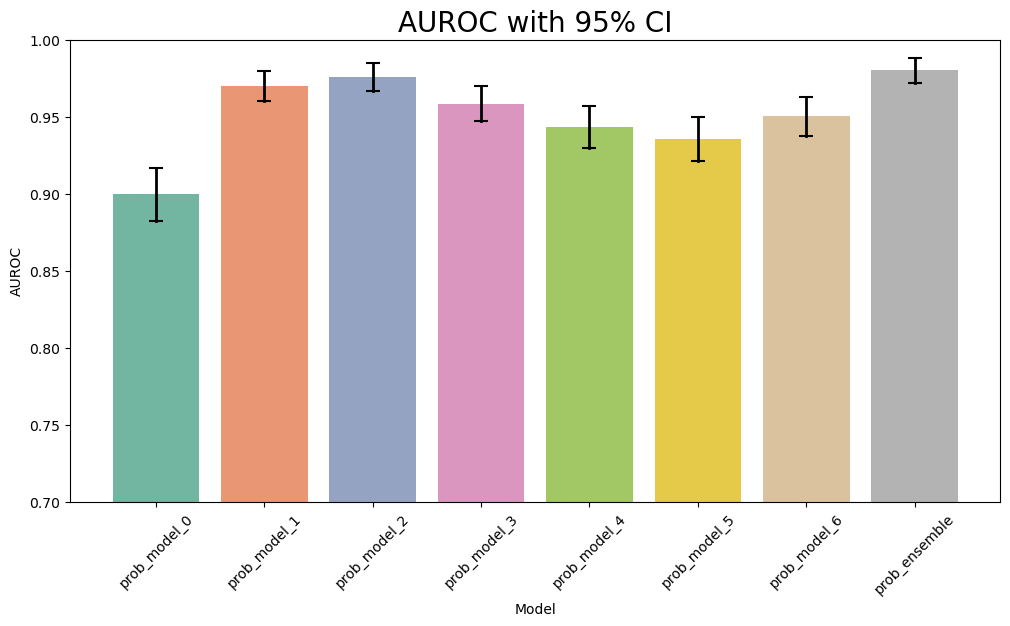

In [19]:
# Calculate AUROC scores with 95% CI
print("\n📊 AUROC Scores (with 95% CI)")
y_true = df['annotation']
auroc_scores = {}
auroc_cis = {}
for col in model_cols + [ensemble_col]:
    # Calculate AUROC
    auroc = roc_auc_score(y_true, df[col])
    auroc_scores[col] = auroc
    
    # Calculate 95% CI using DeLong method approximation
    n1 = sum(y_true == 1)
    n2 = sum(y_true == 0)
    q1 = auroc / (2 - auroc)
    q2 = 2 * (auroc ** 2) / (1 + auroc)
    se = np.sqrt((auroc * (1 - auroc) + (n1 - 1) * (q1 - auroc**2) + (n2 - 1) * (q2 - auroc**2)) / (n1 * n2))
    ci_lower = auroc - 1.96 * se
    ci_upper = auroc + 1.96 * se
    auroc_cis[col] = (ci_lower, ci_upper)
    
    print(f'{col} AUROC: {auroc:.4f} (95% CI: {ci_lower:.4f} - {ci_upper:.4f})')

# Plot AUROC with 95% CI
plt.figure(figsize=(12, 6))
auroc_df = pd.DataFrame(auroc_scores.items(), columns=["Model", "AUROC"])
auroc_df["CI Lower"], auroc_df["CI Upper"] = zip(*auroc_cis.values())
sns.barplot(x="Model", y="AUROC", data=auroc_df, ci=None, palette="Set2")
for i, (ci_lower, ci_upper) in enumerate(auroc_cis.values()):
    plt.plot([i, i], [ci_lower, ci_upper], color="black", linewidth=2)
    plt.scatter([i], [ci_lower], color="black", marker="_", s=100)
    plt.scatter([i], [ci_upper], color="black", marker="_", s=100)
plt.title("AUROC with 95% CI", fontsize=20)
plt.xticks(rotation=45)
plt.ylim(0.7, 1.0)
plt.show()


📊 Sensitivity and Specificity at 95% Thresholds
prob_model_0 - Sensitivity (95% Specificity): 0.5423, Specificity (95% Sensitivity): 0.5929
prob_model_1 - Sensitivity (95% Specificity): 0.8667, Specificity (95% Sensitivity): 0.8607
prob_model_2 - Sensitivity (95% Specificity): 0.9207, Specificity (95% Sensitivity): 0.8566
prob_model_3 - Sensitivity (95% Specificity): 0.7910, Specificity (95% Sensitivity): 0.7992
prob_model_4 - Sensitivity (95% Specificity): 0.6685, Specificity (95% Sensitivity): 0.8067
prob_model_5 - Sensitivity (95% Specificity): 0.6036, Specificity (95% Sensitivity): 0.7259
prob_model_6 - Sensitivity (95% Specificity): 0.7820, Specificity (95% Sensitivity): 0.7505
prob_ensemble - Sensitivity (95% Specificity): 0.8955, Specificity (95% Sensitivity): 0.8718


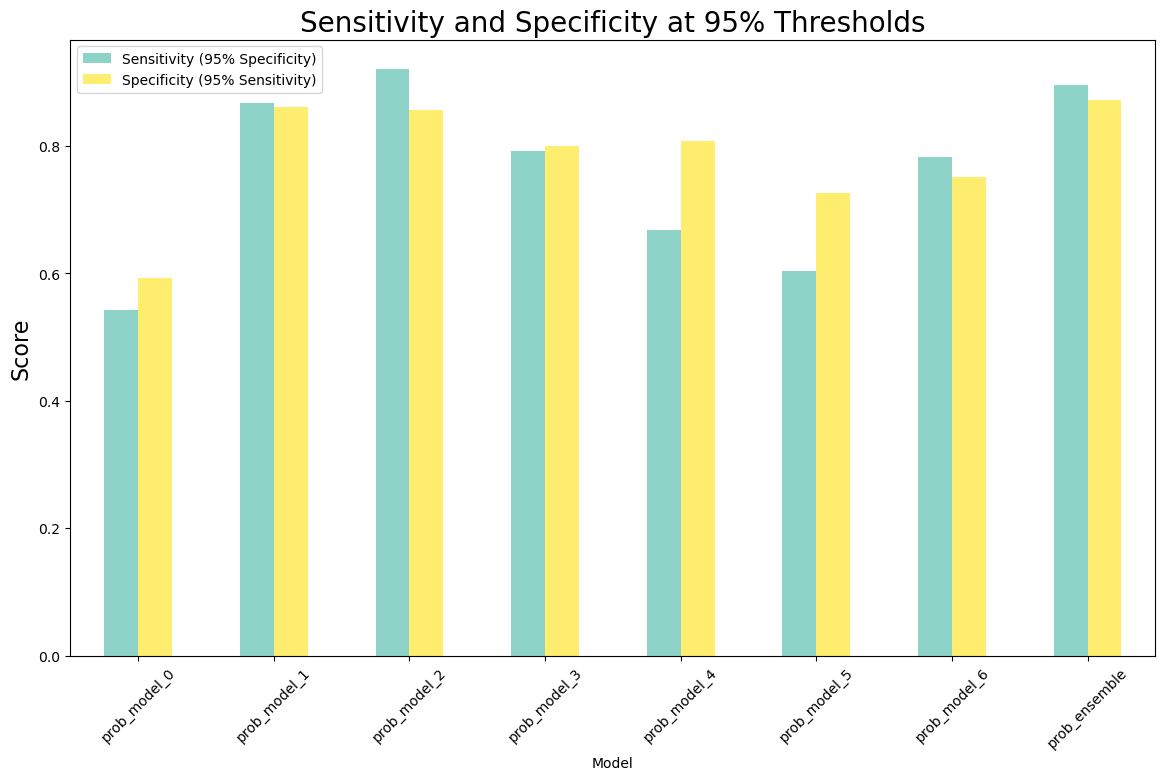

In [20]:
y_true = df['annotation']

# Sensitivity at 95% Specificity & Specificity at 95% Sensitivity
print("\n📊 Sensitivity and Specificity at 95% Thresholds")
threshold_metrics = {}
for col in model_cols + [ensemble_col]:
    fpr, tpr, thresholds = roc_curve(y_true, df[col])

    # Sensitivity at 95% Specificity
    specificity_threshold_idx = np.where(1 - fpr >= 0.95)[0]
    if len(specificity_threshold_idx) > 0:
        sensitivity_95 = max(tpr[specificity_threshold_idx])
    else:
        sensitivity_95 = np.nan

    # Specificity at 95% Sensitivity
    sensitivity_threshold_idx = np.where(tpr >= 0.95)[0]
    if len(sensitivity_threshold_idx) > 0:
        specificity_95 = max(1 - fpr[sensitivity_threshold_idx])
    else:
        specificity_95 = np.nan

    threshold_metrics[col] = (sensitivity_95, specificity_95)
    print(f"{col} - Sensitivity (95% Specificity): {sensitivity_95:.4f}, Specificity (95% Sensitivity): {specificity_95:.4f}")

# Plot Sensitivity and Specificity
threshold_df = pd.DataFrame(threshold_metrics.items(), columns=["Model", "Metrics"])
threshold_df["Sensitivity (95% Specificity)"], threshold_df["Specificity (95% Sensitivity)"] = zip(*threshold_df["Metrics"])
threshold_df.drop(columns=["Metrics"], inplace=True)
threshold_df.set_index("Model", inplace=True)
threshold_df.plot(kind="bar", figsize=(14, 8), colormap="Set3")
plt.title("Sensitivity and Specificity at 95% Thresholds", fontsize=20)
plt.xticks(rotation=45)
plt.ylabel("Score", fontsize=16)
# plt.ylim(0.2, 1.0)
plt.show()


📊 AUROC Scores
prob_model_0 AUROC: 0.8994
prob_model_1 AUROC: 0.9698
prob_model_2 AUROC: 0.9756
prob_model_3 AUROC: 0.9584
prob_model_4 AUROC: 0.9432
prob_model_5 AUROC: 0.9351
prob_model_6 AUROC: 0.9501
prob_ensemble AUROC: 0.9801


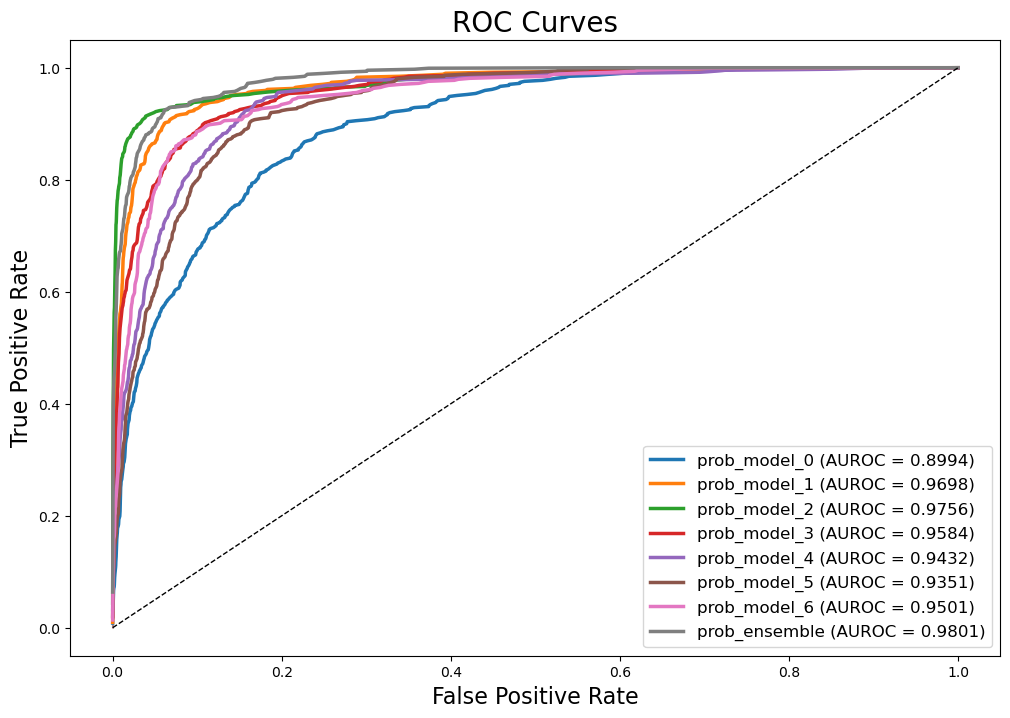

In [21]:
# Calculate AUROC scores
print("\n📊 AUROC Scores")
y_true = df['annotation']
auroc_scores = {}
for col in model_cols + [ensemble_col]:
    auroc_scores[col] = roc_auc_score(y_true, df[col])
    print(f'{col} AUROC: {auroc_scores[col]:.4f}')

# Plot ROC curves (Seaborn)
plt.figure(figsize=(12, 8))
for col in model_cols + [ensemble_col]:
    fpr, tpr, _ = roc_curve(y_true, df[col])
    sns.lineplot(x=fpr, y=tpr, label=f'{col} (AUROC = {auroc_scores[col]:.4f})', linewidth=2.5)

plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
plt.title('ROC Curves', fontsize=20)
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.legend(loc='lower right', fontsize=12)
plt.show()


🔗 Correlation Matrix


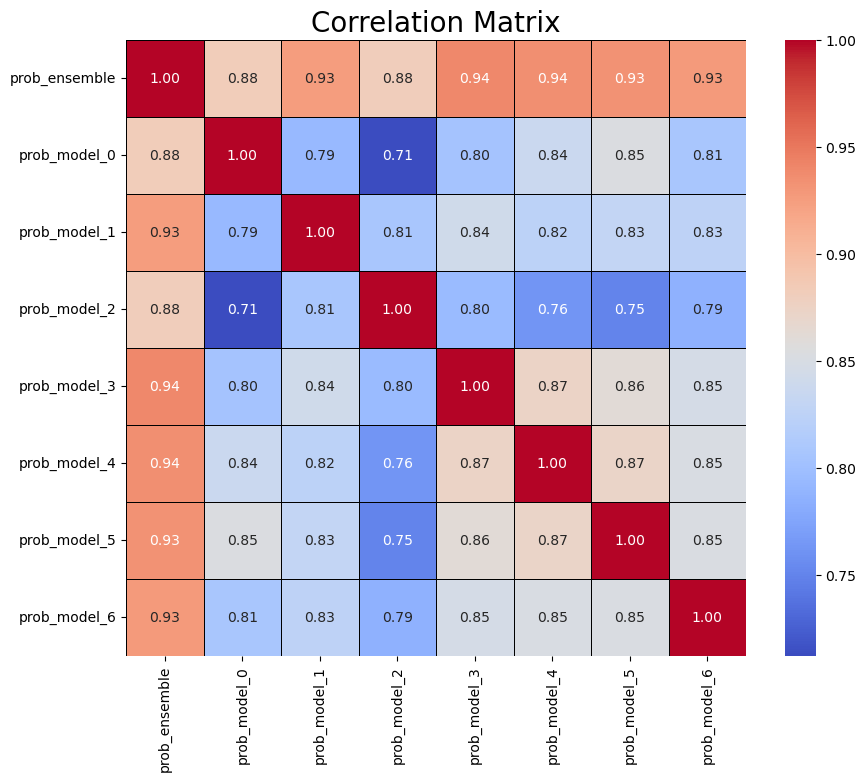

In [22]:
# Correlation matrix (Seaborn)
print("\n🔗 Correlation Matrix")
corr_matrix = df[[ensemble_col] + model_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, linecolor='black')
plt.title('Correlation Matrix', fontsize=20)
plt.show()

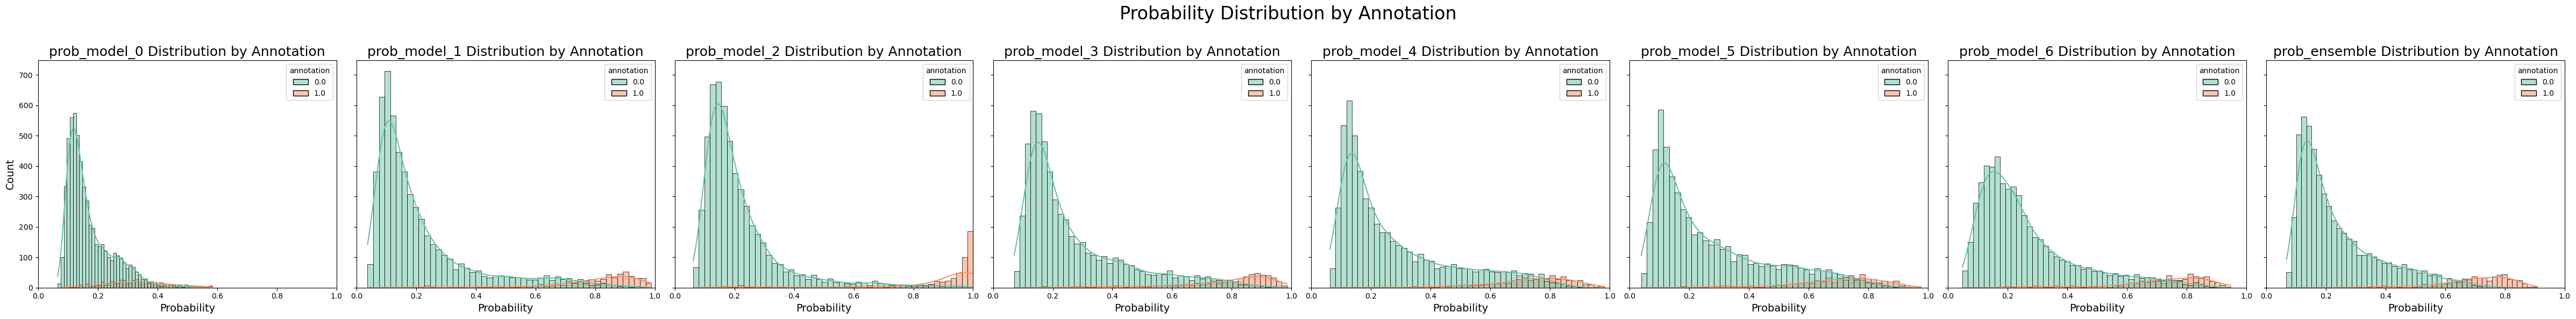

In [23]:
# Probability distribution per annotation (Seaborn, col-wise layout)
_model_cols = model_cols + [ensemble_col]
num_models = len(_model_cols)
fig, axes = plt.subplots(1, num_models, figsize=(6 * num_models, 6), sharey=True)
fig.suptitle("Probability Distribution by Annotation", fontsize=24)

for i, model_col in enumerate(_model_cols):
    sns.histplot(data=df, x=model_col, hue="annotation", bins=50, kde=True, ax=axes[i], alpha=0.5, palette="Set2")
    axes[i].set_title(f"{model_col} Distribution by Annotation", fontsize=18)
    axes[i].set_xlabel("Probability", fontsize=14)
    axes[i].set_ylabel("Count", fontsize=14)
    axes[i].set_xlim(0.0, 1.0)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

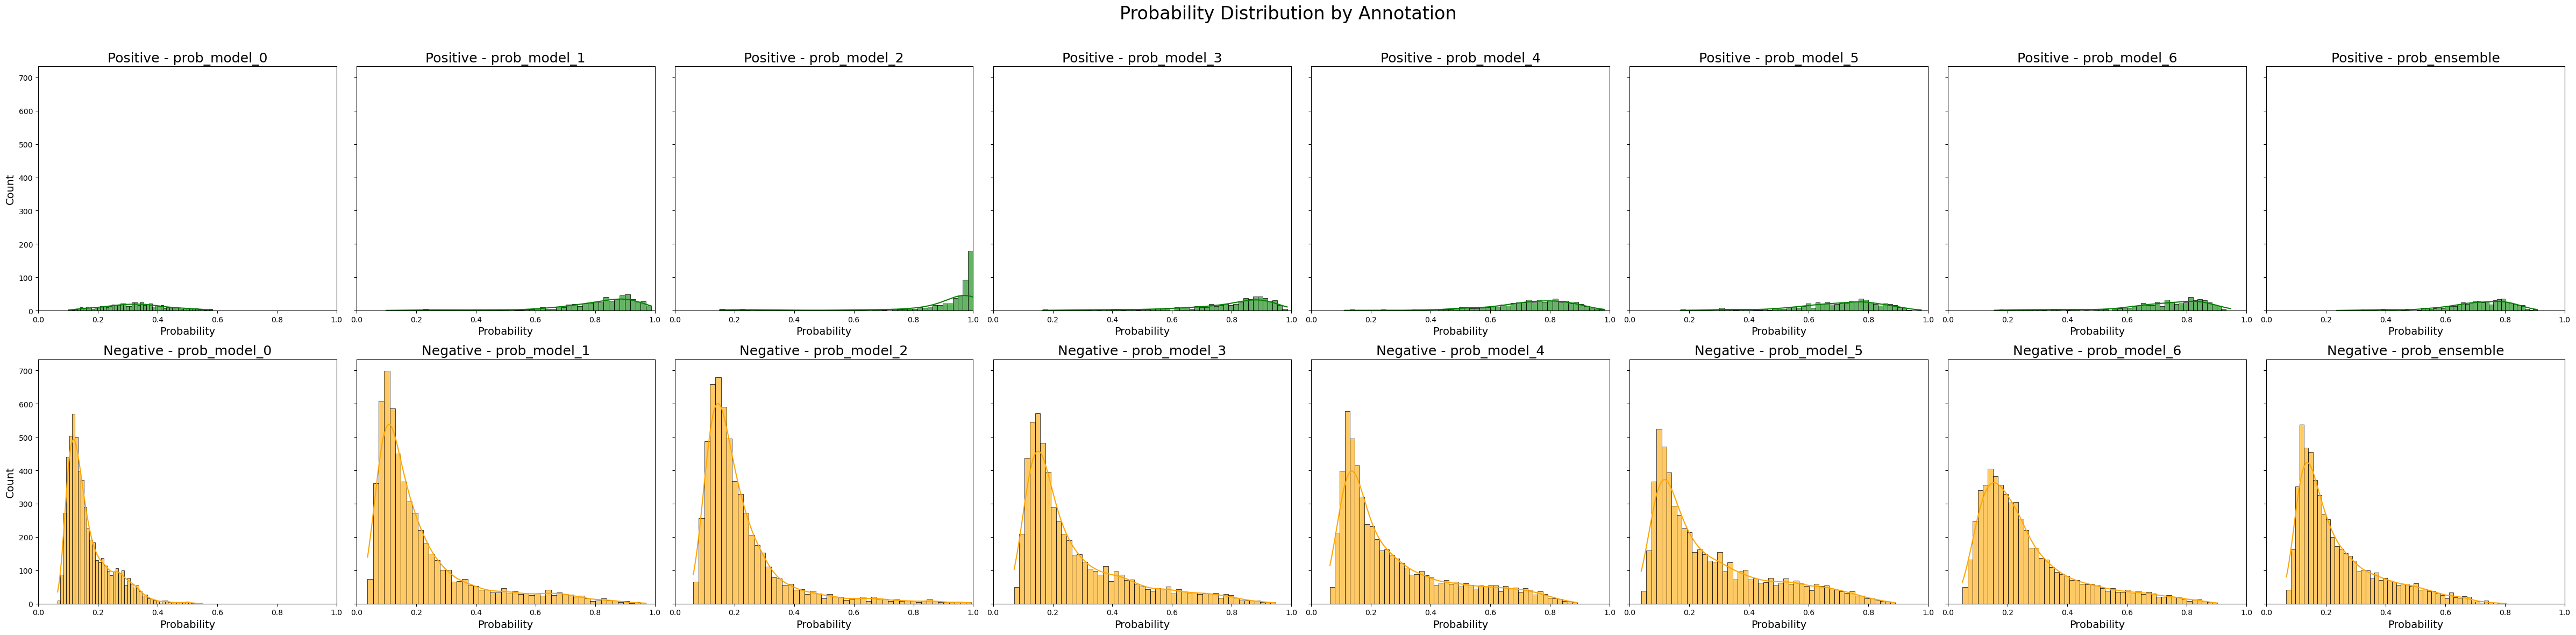

In [24]:
# Extract model probability columns (e.g., prob_model_0, prob_model_1, ...)
_model_cols = model_cols + [ensemble_col]

# Probability distribution by annotation (Seaborn, row-wise layout)
num_models = len(_model_cols)
fig, axes = plt.subplots(2, num_models, figsize=(6 * num_models, 12), sharey=True)
fig.suptitle("Probability Distribution by Annotation", fontsize=24)

for i, model_col in enumerate(_model_cols):
    # Positive annotation
    sns.histplot(data=df[df['annotation'] == 1], x=model_col, bins=50, kde=True, ax=axes[0, i], alpha=0.6, color="green")
    axes[0, i].set_title(f"Positive - {model_col}", fontsize=18)
    axes[0, i].set_xlabel("Probability", fontsize=14)
    axes[0, i].set_ylabel("Count", fontsize=14)
    axes[0, i].set_xlim(0.0, 1.0)

    # Negative annotation
    sns.histplot(data=df[df['annotation'] == 0], x=model_col, bins=50, kde=True, ax=axes[1, i], alpha=0.6, color="orange")
    axes[1, i].set_title(f"Negative - {model_col}", fontsize=18)
    axes[1, i].set_xlabel("Probability", fontsize=14)
    axes[1, i].set_ylabel("Count", fontsize=14)
    axes[1, i].set_xlim(0.0, 1.0)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


🧮 Entropy Analysis

📝 Entropy Summary
       prob_model_0  prob_model_1  prob_model_2  prob_model_3  prob_model_4  \
count   6163.000000   6163.000000   6163.000000   6163.000000   6163.000000   
mean       0.584753      0.499805      0.573025      0.547809      0.598229   
std        0.206410      0.206608      0.220431      0.208239      0.197676   
min        0.241749      0.170339      0.003670      0.204407      0.266340   
25%        0.415084      0.350686      0.394931      0.383204      0.430911   
50%        0.522532      0.426260      0.537598      0.487569      0.533211   
75%        0.753550      0.589067      0.738750      0.694440      0.758865   
max        1.000000      0.999998      0.999999      1.000000      0.999999   

       prob_model_5  prob_model_6  prob_ensemble  
count   6163.000000   6163.000000    6163.000000  
mean       0.622917      0.545029       0.588328  
std        0.190095      0.202530       0.200574  
min        0.256520      0.154305       0.270

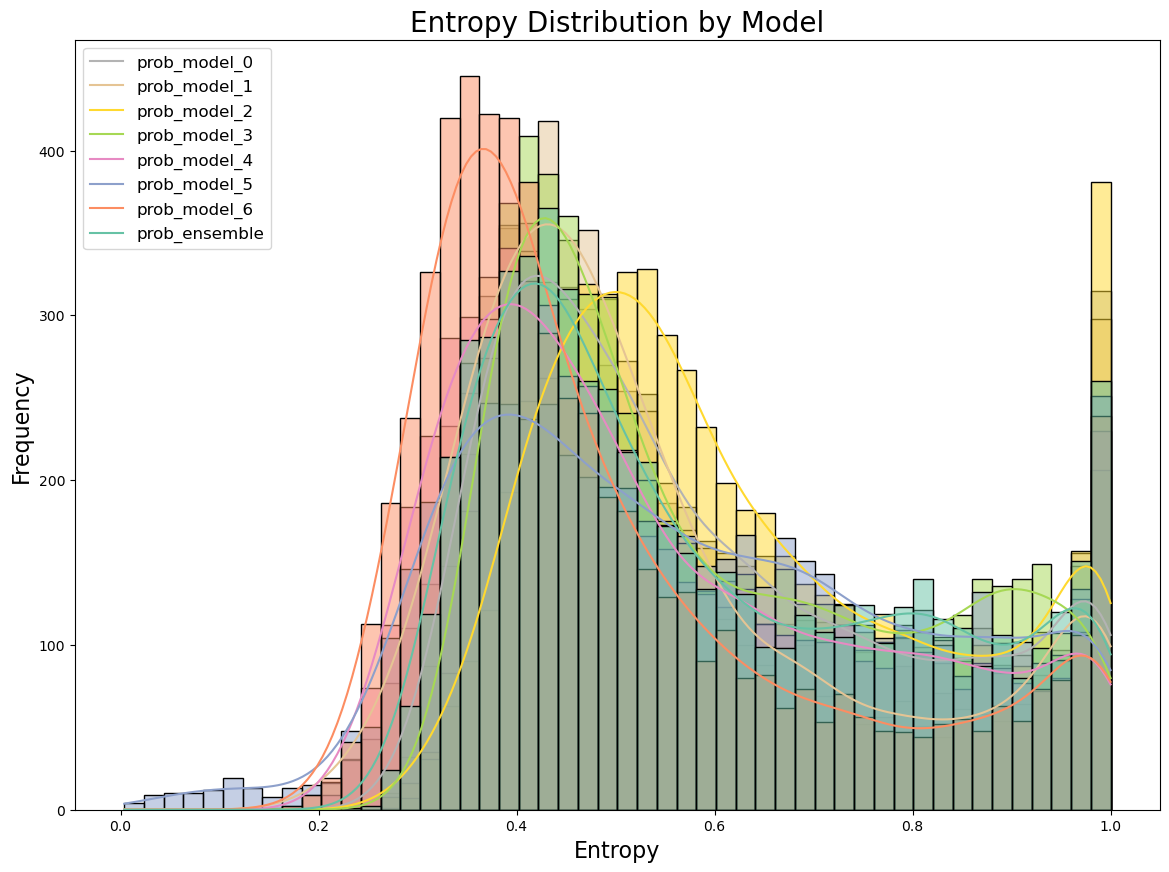

In [11]:
# Entropy calculation
print("\n🧮 Entropy Analysis")
entropy_df = pd.DataFrame()
for col in model_cols + [ensemble_col]:
    probs = df[col].values
    entropies = -(probs * np.log2(probs + 1e-10) + (1 - probs) * np.log2(1 - probs + 1e-10))
    entropy_df[col] = entropies

# Entropy summary
print("\n📝 Entropy Summary")
print(entropy_df.describe())

# Plot entropy distributions (Seaborn)
plt.figure(figsize=(14, 10))
sns.histplot(entropy_df, kde=True, bins=50, alpha=0.5, palette='Set2')
plt.title('Entropy Distribution by Model', fontsize=20)
plt.xlabel('Entropy', fontsize=16)
plt.ylabel('Frequency', fontsize=16)
plt.legend(entropy_df.columns, fontsize=12)
plt.show()

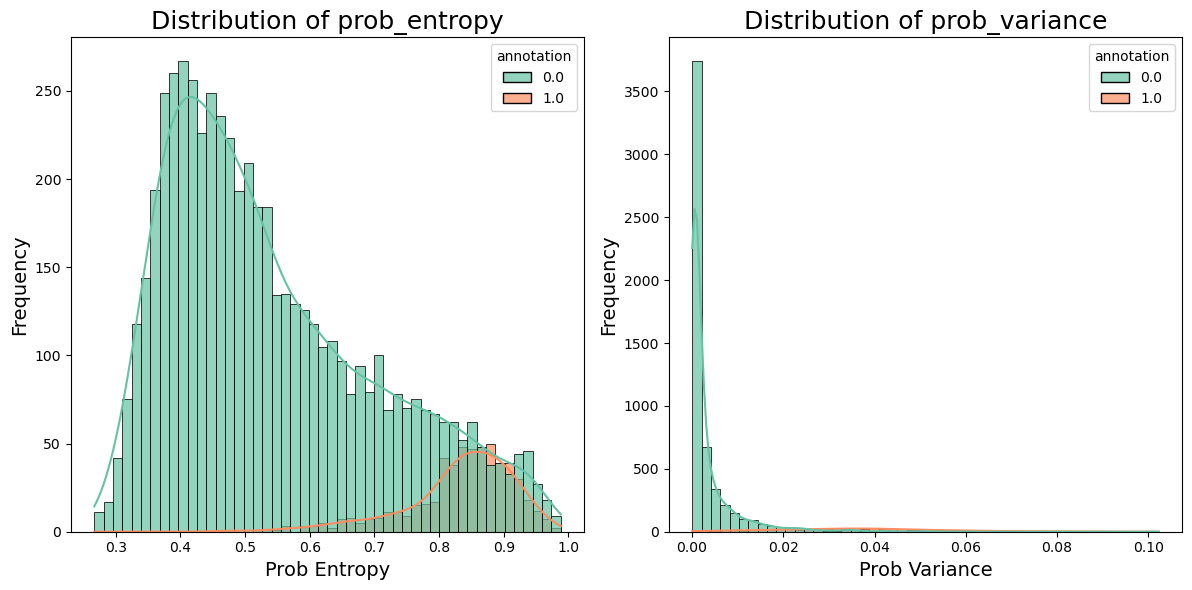


📝 Metric Summary Statistics
       prob_entropy  prob_variance
count   6163.000000    6163.000000
mean       0.567367       0.006289
std        0.177897       0.012424
min        0.266591       0.000014
25%        0.420437       0.000387
50%        0.519332       0.001163
75%        0.703568       0.005115
max        0.988146       0.102277


In [12]:
# Extract model probability columns (e.g., prob_model_0, prob_model_1, ...)
ensemble_col = 'prob_ensemble'
model_cols = [col for col in df.columns if col.startswith('prob_model_')]

# Correct entropy calculation for binary classification
binary_entropies = []
for _, row in df[model_cols].iterrows():
    entropies = - (row.values * np.log2(row.values + 1e-10) + (1 - row.values) * np.log2(1 - row.values + 1e-10))
    binary_entropies.append(np.mean(entropies))

df["prob_entropy"] = binary_entropies
df["prob_variance"] = df[model_cols].var(axis=1)

# Plot distributions
metrics = ["prob_entropy", "prob_variance"]
plt.figure(figsize=(18, 6))
for i, metric in enumerate(metrics):
    plt.subplot(1, 3, i + 1)
    sns.histplot(data=df, x=metric, hue="annotation", bins=50, kde=True, palette="Set2", alpha=0.7)
    plt.title(f"Distribution of {metric}", fontsize=18)
    plt.xlabel(metric.replace('_', ' ').title(), fontsize=14)
    plt.ylabel("Frequency", fontsize=14)
plt.tight_layout()
plt.show()

# Summary statistics
print("\n📝 Metric Summary Statistics")
print(df[metrics].describe())

In [13]:
# Sort by entropy, variance, and CV for each annotation
sorted_positive = df[df["annotation"] == 1].sort_values(by="prob_variance", ascending=False)
sorted_negative = df[df["annotation"] == 0].sort_values(by="prob_variance", ascending=False)

# Select top N samples
N = 20
top_positive = sorted_positive.head(N)
top_negative = sorted_negative.head(N)

# Display the selected samples
print("\n🔎 Top Positive Samples (High variance)")
print(top_positive[["annotation", "prob_entropy", "prob_variance"] + model_cols].reset_index(drop=True))

print("\n🔎 Top Negative Samples (High variance)")
print(top_negative[["annotation", "prob_entropy", "prob_variance"] + model_cols].reset_index(drop=True))


🔎 Top Positive Samples (High variance)
    annotation  prob_entropy  prob_variance  prob_model_0  prob_model_1  \
0          1.0      0.695103       0.102277      0.231055      0.793334   
1          1.0      0.676021       0.085667      0.189891      0.816778   
2          1.0      0.660886       0.085333      0.173722      0.209653   
3          1.0      0.673337       0.084433      0.157283      0.295911   
4          1.0      0.730874       0.083884      0.243806      0.450438   
5          1.0      0.768167       0.082904      0.384623      0.840972   
6          1.0      0.710498       0.082222      0.240484      0.333205   
7          1.0      0.695293       0.080577      0.147719      0.385279   
8          1.0      0.735976       0.079150      0.346405      0.317625   
9          1.0      0.770006       0.078558      0.311648      0.613402   
10         1.0      0.726192       0.077996      0.477620      0.928948   
11         1.0      0.663494       0.077212      0.162078   

In [14]:
import pymongo

from data_lake.constants import DB_ADDRESS, TARGET_COLLECTION, TARGET_DB

_CLIENT = pymongo.MongoClient(DB_ADDRESS)
_TARGET_FIELD = {}
_PROJECTION = {field: 1 for field in _TARGET_FIELD}

for _, row in top_positive.iterrows():
    query = {"annotation_id": row.annot_ids}
    nodule_candidates = [x for x in _CLIENT[TARGET_DB][TARGET_COLLECTION].find(query, _PROJECTION)]
    break


In [15]:
nodule_candidates

[{'_id': ObjectId('67f76d765ca4e585263d4664'),
  'patient_id': 210090,
  'series_instance_uid': '1.3.6.1.4.1.14519.5.2.1.7009.9004.148800903815565314876573314988',
  'annotation_id': '210090_2_20010102',
  'studydate': 20010102,
  'h5_path_nfs': '/team/team_blu3/lung/data/2_public/LUNA25_h5/1.3.6.1.4.1.14519.5.2.1.7009.9004.148800903815565314876573314988.h5',
  'h5_path': '/nvme1/1_dataset/LUNA25_h5/1.3.6.1.4.1.14519.5.2.1.7009.9004.148800903815565314876573314988.h5',
  'fold': 3,
  'label': 1,
  'age_at_study': 70,
  'gender': 'Male',
  'origin': [-361.29998779296875, -348.63671875, -196.63671875],
  'transform': [[1.7999999523162842, 0.0, 0.0],
   [0.0, 0.7265625, 0.0],
   [0.0, 0.0, 0.7265625]],
  'spacing': [1.7999999523162842, 0.7265625, 0.7265625],
  'resampled_spacing': [1.0, 0.67, 0.67],
  'w_coord_zyx': [-226.3000031, -83.48855591, -43.30151367],
  'd_coord_zyx': [74.99999348291507, 364.93510584430106, 211.0420026907527],
  'r_coord_zyx': [135.08521553456862, 395.6439307979311